## 学習と精度を確認する
- 年次ホールドアウト + StratifiedKFold（TF‑IDFはfold内fit, LightGBM）
- 直近 TEST_LAST_N 年を最終テストとして完全にホールドアウト
- それ以前のデータのみで StratifiedKFold を実施（情報リーク防止のため TF‑IDF は fold学習データでfit）
- OOF で 閾値最適化（macro_f1 または balanced_accuracy）

In [162]:
from importlib import reload

from classification import ml_token_classification_rf
from classification import ml_token_classification_xgb
from classification import ml_token_classification_lgb

from classification import ml_numerical_classification_rf
from classification import ml_numerical_classification_xgb
from classification import ml_numerical_classification_lgb

from classification import cm

from sklearn.model_selection import train_test_split

import numpy as np


In [163]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

# ====== パラメータ（必要に応じて変更） ======
RANDOM_SEED = 42
N_SPLITS = 6
# 列名
TEXT_COL = "description"          # テキスト列
LABEL_BINARY_COL = "eval_binary"  # 目的変数（0/1）
YEAR_COL = "project_start_year"   # 年度列（数値化可能であること）
THRESHOLD = 100 # 閾値
THRESH_OBJECTIVE = "balanced_accuracy"  # 閾値最適化の指標

# テストに使う直近年数
TEST_LAST_N = 5                  # 例: 直近2年をテスト

# TF-IDF
TFIDF_MAX_FEATURES = 5000
TFIDF_MIN_DF = 3
TFIDF_NGRAM = (1, 2)
# テキストベクトル化の方式を切替
# - 'char': 日本語向けに手軽な文字n-gram（デフォルト）
# - 'word': 形態素解析（fugashi）で単語n-gram
TEXT_TOKENIZER = 'char'  # 'word' or 'word'
CHAR_NGRAM = (2, 4)      # analyzer='char_wb' 時の ngram_range
WORD_NGRAM = (1, 1)      # analyzer='word'（形態素）の ngram_range

# cost_success_flg, duration_success_flg, total_eval
SOURCE_ORDINAL_COL = "total_eval"

# LightGBM デフォルト
LGB_PARAMS = dict(
    objective="binary",
    n_estimators=5000,
    learning_rate=0.02,
    num_leaves=63,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    is_unbalance=True,  # クラス不均衡設定
)

In [164]:
import pandas as pd
df = pd.read_csv("../df_check_ml.csv")  # ←必要ならCSV読み込み

df.columns

Index(['Unnamed: 0_x', 'file', 'country', 'eval_year', 'evaluator_group',
       'evaluator', 'project_cost_plan', 'project_cost_act', 'プロジェクト期間開始_計画時',
       'プロジェクト期間終了_計画時', 'プロジェクト期間開始_実績', 'プロジェクト期間終了_実績',
       'project_duration_plan', 'project_duration_act', '妥当性評価', '整合性評価',
       '有効性評価', 'インパクト評価', '効率性評価', '効率性_コスト', '効率性_期間', '持続性評価', '適応・貢献評価',
       '付加価値・創造価値評価', '総合評価', '備考', 'type', '分野', '案件名', '連番', 'region',
       'region_detail', 'alpha2', 'alpha3', 'project_start_year',
       'project_end_year', 'join_flg_x', 'Year', 'external_eval_flg',
       'その他_flg_fix', 'インフラ_flg_fix', 'エネルギー一般_flg_fix', '人材・教育_flg_fix',
       '保健・社会福祉_flg_fix', '公益事業一般_flg_fix', '商業経営_flg_fix', '工業_flg_fix',
       '放送_flg_fix', '林業・森林保全_flg_fix', '水産_flg_fix', '水資源開発_flg_fix',
       '海運_flg_fix', '測量・地図_flg_fix', '災害・食料援助_flg_fix', '災害対策_flg_fix',
       '環境_flg_fix', '畜産_flg_fix', '社会基盤一般_flg_fix', '航空・空港_flg_fix',
       '行政一般_flg_fix', '観光一般_flg_fix', '貿易_flg_fix', '農業一般_flg_fix

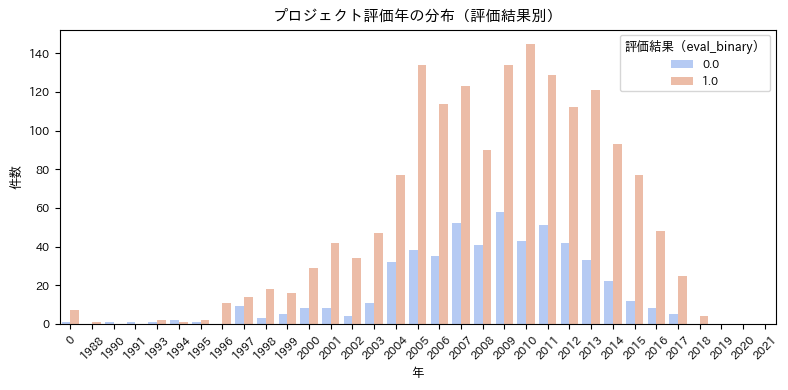

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(
    data=df,
    x=YEAR_COL,
    hue="eval_binary",
    palette="coolwarm"
)
plt.title("プロジェクト評価年の分布（評価結果別）", fontsize=11)  # タイトル小さく
plt.xlabel("年", fontsize=9)                     # 軸ラベル小さく
plt.ylabel("件数", fontsize=9)
plt.xticks(rotation=45, fontsize=8)                              # x軸目盛りの文字サイズ
plt.yticks(fontsize=8)                                           # y軸目盛りの文字サイズ
plt.legend(title="評価結果（eval_binary）", fontsize=8, title_fontsize=9)
plt.tight_layout()
plt.show()

In [166]:
# 利用するテキストの特徴量を生成
df['sentence'] = df['background']+df['description']

In [167]:
## textがないレコードを除外
print(df['sentence'].isnull().sum())
df = df.dropna(subset=['sentence'])

12


In [168]:
## 評価がないレコードを除外
print(df['eval_binary'].isnull().sum())
df = df.dropna(subset=['eval_binary'])

46


In [169]:
df = df.rename(columns={
  LABEL_BINARY_COL: "label",
})

In [170]:
## train_test分割
train_df = df[df[YEAR_COL] <= (df[YEAR_COL].max() - TEST_LAST_N)]
valid_df = df[df[YEAR_COL] > (df[YEAR_COL].max() - TEST_LAST_N)]

# RandomForest
### 実施内容だけでの予測

Accuracy: 0.8424657534246576
Precision: 0.9209621993127148
Recall: 0.5106382978723404
Macro F1: 0.47792288557213924
Balanced Accuracy: 0.5106382978723404
SHAP values array shape: (2, 292, 8259)


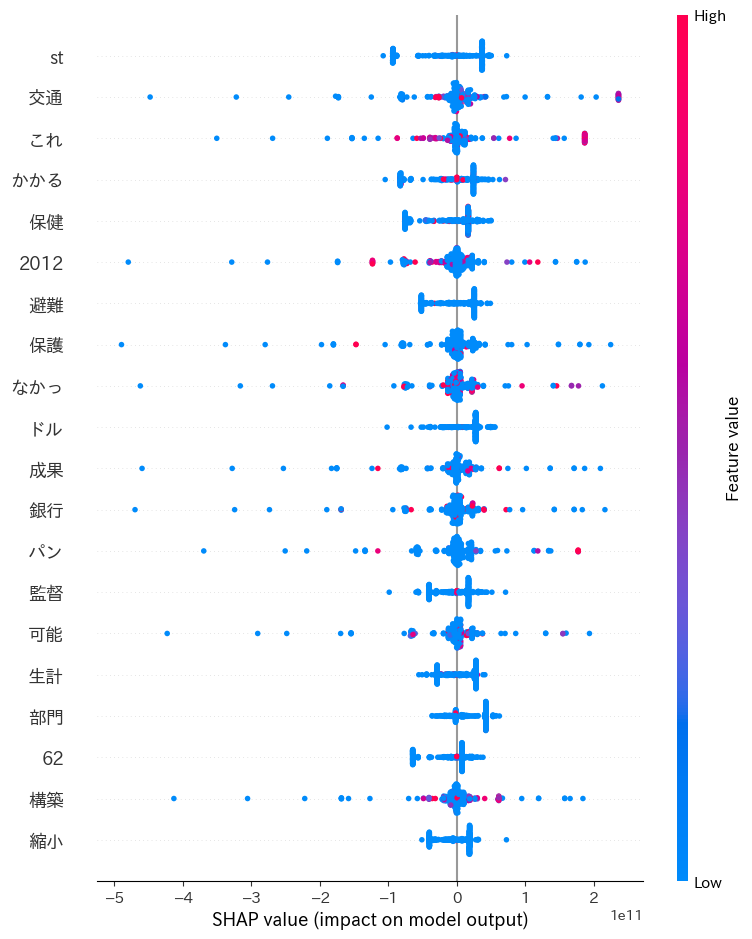

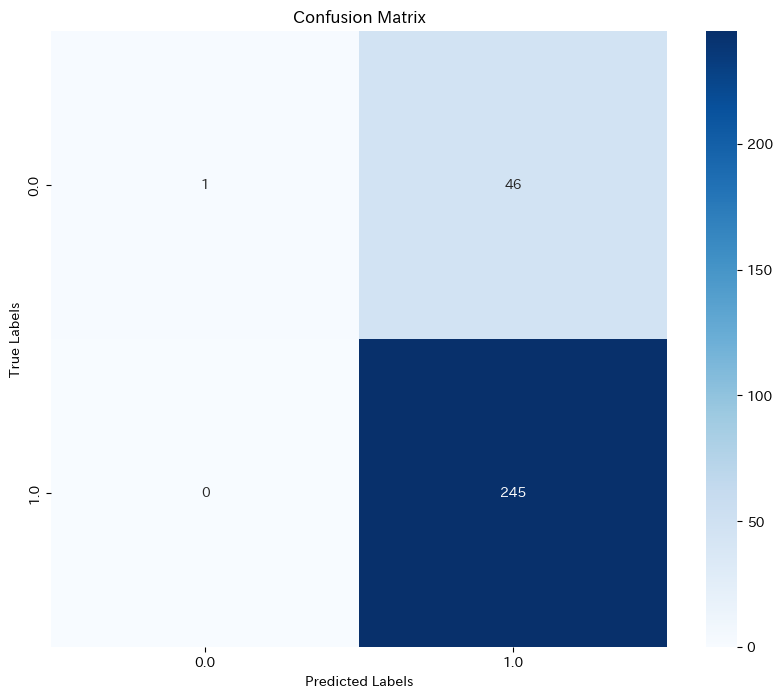

method, class, accuracy, precision, recall
proposed, all, 0.8424657534246576, 0.9209621993127148, 0.5106382978723404
proposed, 0.0, non, 1.0, 0.02127659574468085
proposed, 1.0, non, 0.8419243986254296, 1.0
baseline, all, 0.7298977294051416, 0.5, 0.5
baseline, 0.0, non, 0.16095890410958905, 0.16095890410958905
baseline, 1.0, non, 0.839041095890411, 0.839041095890411


In [171]:

reload(ml_token_classification_rf)

ml_token_classification_rf.train_and_evaluate_model(train_df=train_df, valid_df=valid_df, model_name="cl-tohoku/bert-base-japanese-v3")
cm.vis('results/classification/confusion_matrix_text_rf.csv','results/classification/result_text_rf.csv')


# XGBoost
### 実施内容だけでの予測

[15:46:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Accuracy: 0.7636986301369864
Precision: 0.49735576923076924
Recall: 0.4980894485453756
Macro F1: 0.494974307557338
Balanced Accuracy: 0.4980894485453756
2


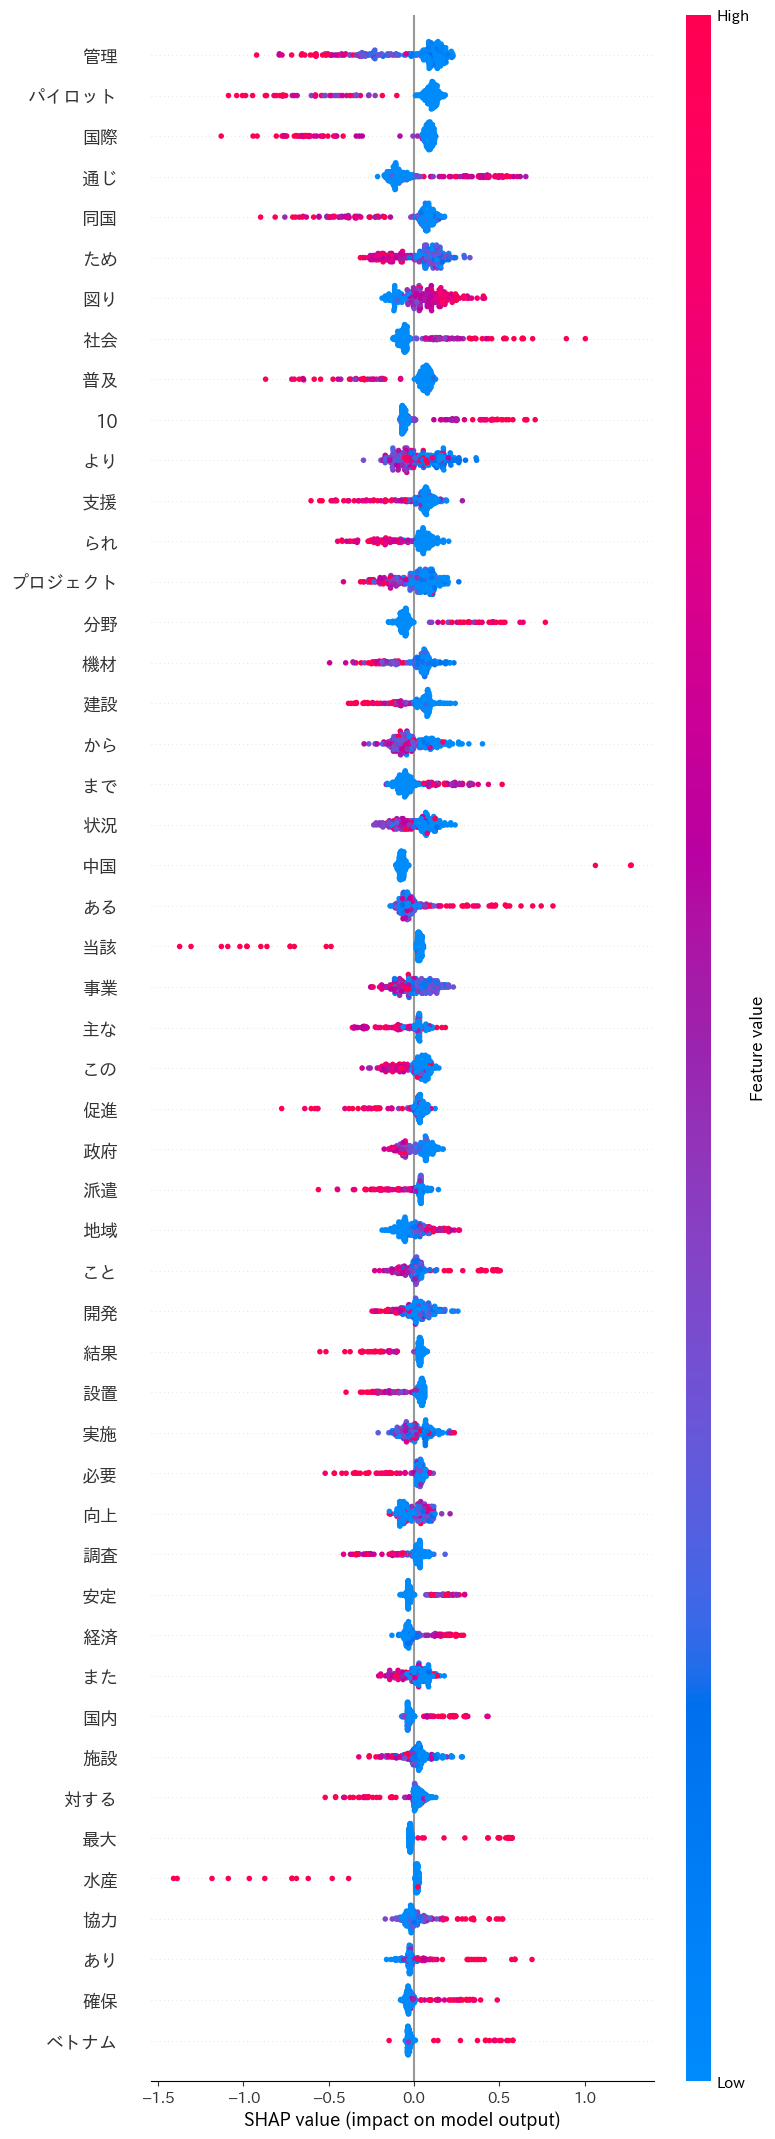

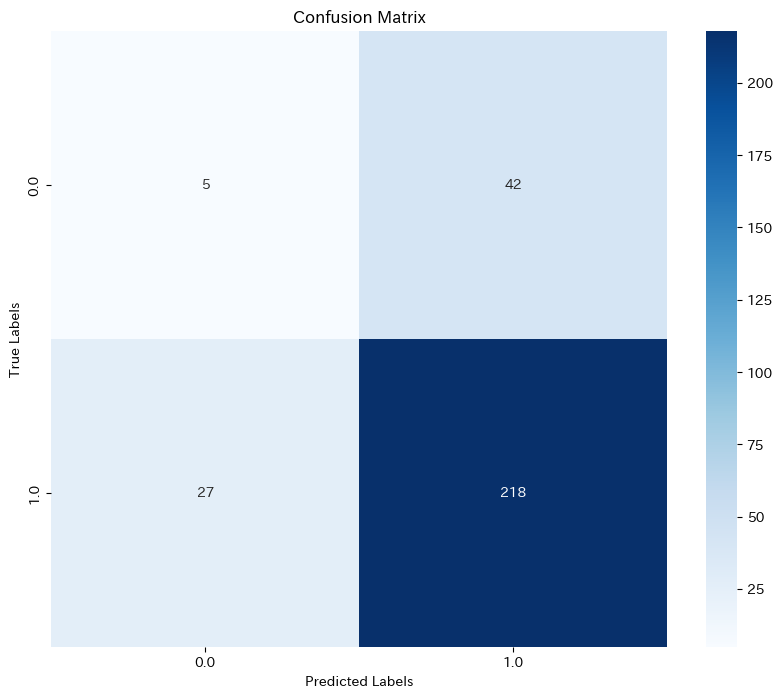

method, class, accuracy, precision, recall
proposed, all, 0.7636986301369864, 0.49735576923076924, 0.4980894485453756
proposed, 0.0, non, 0.15625, 0.10638297872340426
proposed, 1.0, non, 0.8384615384615385, 0.889795918367347
baseline, all, 0.7298977294051416, 0.5, 0.5
baseline, 0.0, non, 0.16095890410958905, 0.16095890410958905
baseline, 1.0, non, 0.839041095890411, 0.839041095890411


In [172]:
reload(ml_token_classification_xgb)
ml_token_classification_xgb.train_and_evaluate_model(train_df=train_df, valid_df=valid_df, model_name="cl-tohoku/bert-base-japanese-v3")
cm.vis('results/classification/confusion_matrix_text_xgb.csv','results/classification/result_text_xgb.csv')


# LighGBM
### 実施内容だけでの予測

[LightGBM] [Info] Number of positive: 1399, number of negative: 478
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67880
[LightGBM] [Info] Number of data points in the train set: 1877, number of used features: 1800
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.745338 -> initscore=1.073902
[LightGBM] [Info] Start training from score 1.073902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

 99%|===================| 290/292 [01:27<00:00]        

2


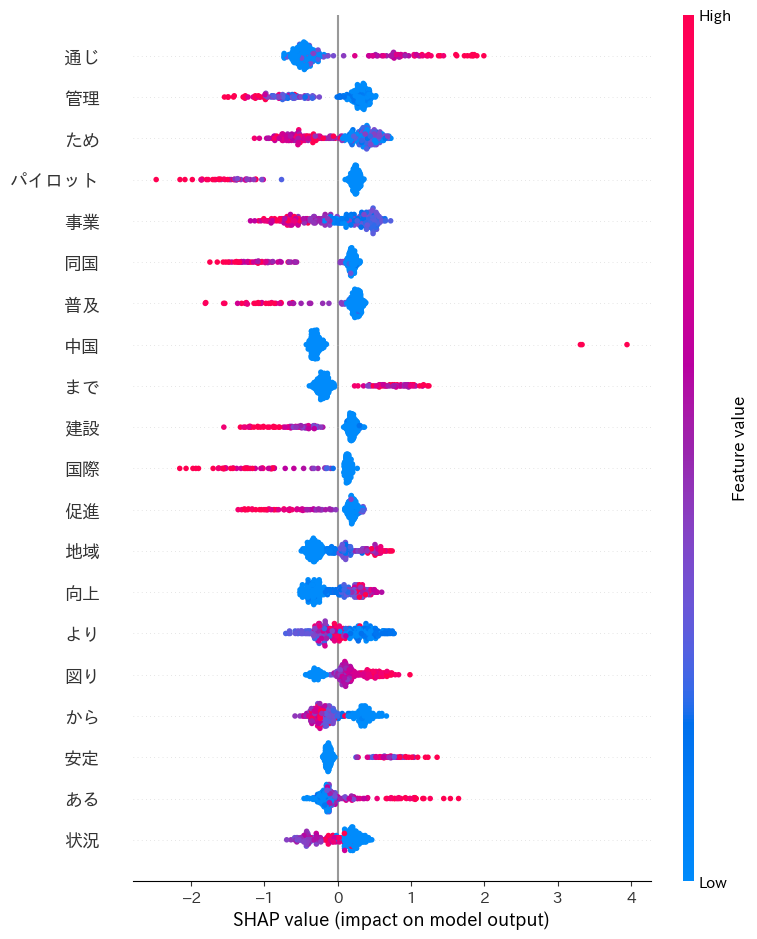

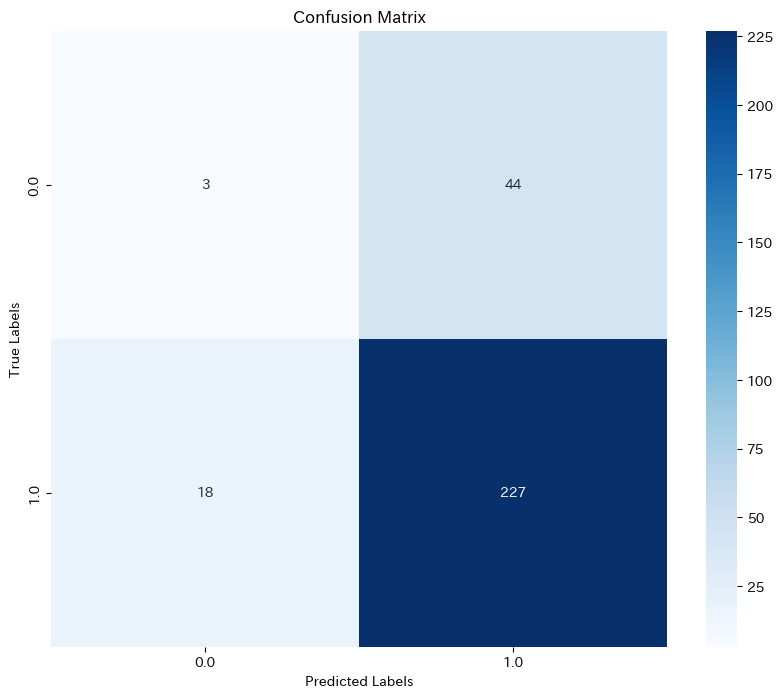

method, class, accuracy, precision, recall
proposed, all, 0.7876712328767124, 0.4902477596204533, 0.49518019973947025
proposed, 0.0, non, 0.14285714285714285, 0.06382978723404255
proposed, 1.0, non, 0.8376383763837638, 0.926530612244898
baseline, all, 0.7298977294051416, 0.5, 0.5
baseline, 0.0, non, 0.16095890410958905, 0.16095890410958905
baseline, 1.0, non, 0.839041095890411, 0.839041095890411


In [173]:
reload(ml_token_classification_lgb)
ml_token_classification_lgb.train_and_evaluate_model(train_df=train_df, valid_df=valid_df, model_name="cl-tohoku/bert-base-japanese-v3")
cm.vis('results/classification/confusion_matrix_text_lgb.csv','results/classification/result_text_lgb.csv')


## テキスト外特徴量の追加

## 特徴量指定

In [174]:
df.columns

Index(['Unnamed: 0_x', 'file', 'country', 'eval_year', 'evaluator_group',
       'evaluator', 'project_cost_plan', 'project_cost_act', 'プロジェクト期間開始_計画時',
       'プロジェクト期間終了_計画時', 'プロジェクト期間開始_実績', 'プロジェクト期間終了_実績',
       'project_duration_plan', 'project_duration_act', '妥当性評価', '整合性評価',
       '有効性評価', 'インパクト評価', '効率性評価', '効率性_コスト', '効率性_期間', '持続性評価', '適応・貢献評価',
       '付加価値・創造価値評価', '総合評価', '備考', 'type', '分野', '案件名', '連番', 'region',
       'region_detail', 'alpha2', 'alpha3', 'project_start_year',
       'project_end_year', 'join_flg_x', 'Year', 'external_eval_flg',
       'その他_flg_fix', 'インフラ_flg_fix', 'エネルギー一般_flg_fix', '人材・教育_flg_fix',
       '保健・社会福祉_flg_fix', '公益事業一般_flg_fix', '商業経営_flg_fix', '工業_flg_fix',
       '放送_flg_fix', '林業・森林保全_flg_fix', '水産_flg_fix', '水資源開発_flg_fix',
       '海運_flg_fix', '測量・地図_flg_fix', '災害・食料援助_flg_fix', '災害対策_flg_fix',
       '環境_flg_fix', '畜産_flg_fix', '社会基盤一般_flg_fix', '航空・空港_flg_fix',
       '行政一般_flg_fix', '観光一般_flg_fix', '貿易_flg_fix', '農業一般_flg_fix

In [175]:
df['evaluator_group'] = df['evaluator_group'].replace({',':''})

In [176]:
ohe_col = [
    #'project_start_year',
    'country',
    'region_detail',
    'type',
]
df = pd.get_dummies(df, columns=ohe_col)


# 例: 既存ノートのfeaturesを再掲。必要に応じて変更/追加してください。
features = [
    'project_cost_plan', 
    'project_duration_plan', 
    'control_of_corruption', 
    'government_effectiveness', 
    'political_stability', 
    'regulatory_quality', 
    'rule_of_law', 
    'voice_and_accountability', 
    'freedom_house_score', 
    'gdp_growth', 
    'population', 
]

# one-hot列
country_columns = [c for c in df.columns if c.startswith('country_')]
type_columns = [c for c in df.columns if c.startswith('type_')]
region_columns = [c for c in df.columns if c.startswith('region_detail_')]
project_start_year_columns = [c for c in df.columns if c.startswith('project_start_year')]
sector_columns = [c for c in df.columns if 'flg_fix' in c]
eva_columns = [c for c in df.columns if c.startswith('evaluator_group_')]

features = features + country_columns + type_columns + region_columns + sector_columns + eva_columns


## RandomForest
- 数値系特徴量の追加

In [177]:
## random forest用にNaN特徴量の行を除外
df_random = df.dropna(subset=features)
## train_test分割
train_rf_df = df_random[df_random[YEAR_COL] <= (df_random[YEAR_COL].max() - TEST_LAST_N)][features + ['label']] 
valid_rf_df = df_random[df_random[YEAR_COL] > (df_random[YEAR_COL].max() - TEST_LAST_N)][features + ['label']] 

Accuracy: 0.8304498269896193
Precision: 0.6543680297397769
Recall: 0.5730174081237911
Macro F1: 0.5863831527295031
Balanced Accuracy: 0.5730174081237911
SHAP values array shape: (2, 289, 200)


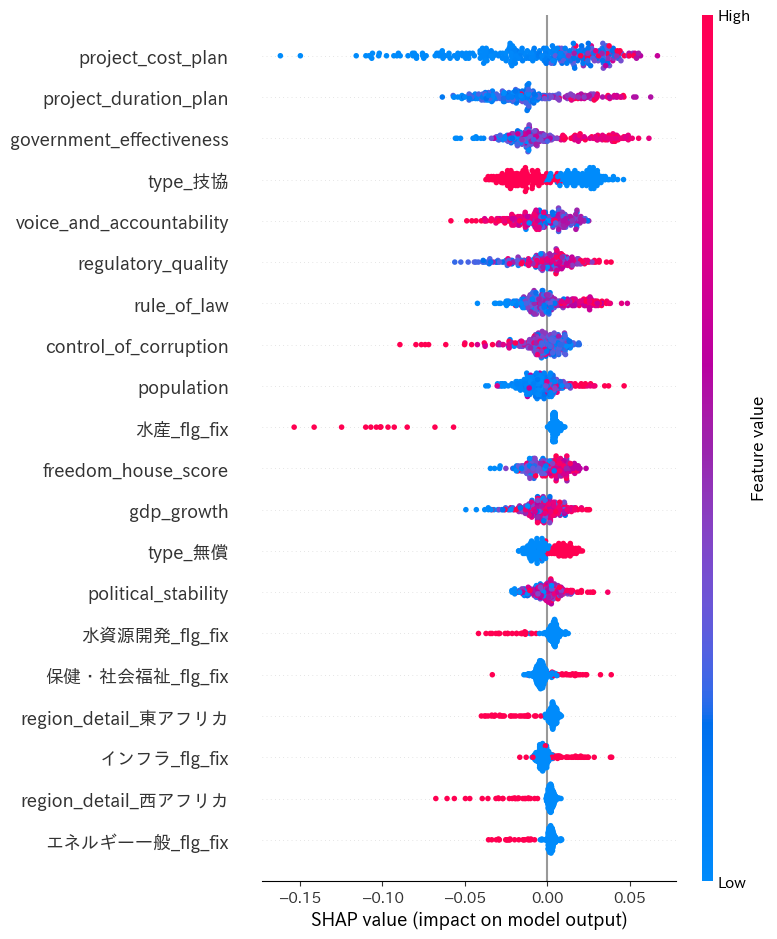

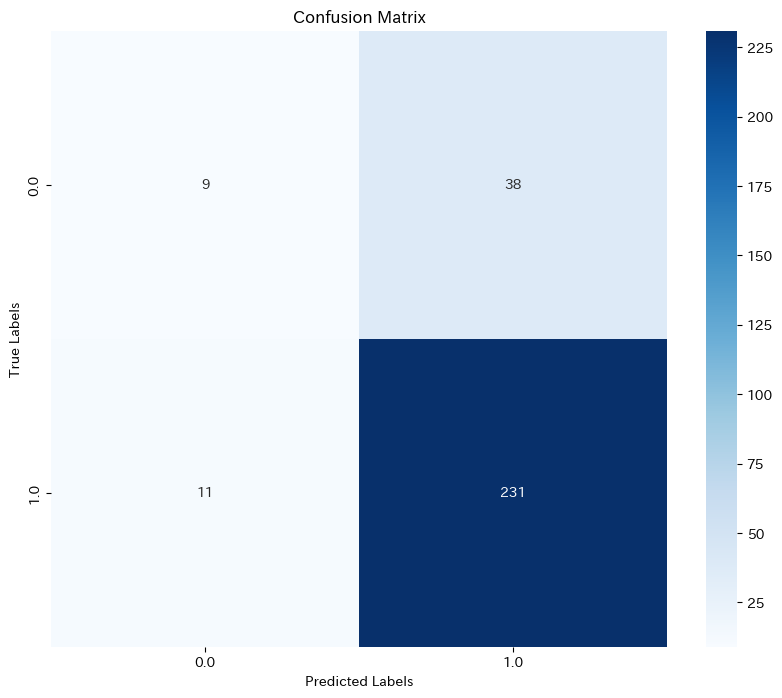

method, class, accuracy, precision, recall
proposed, all, 0.8304498269896193, 0.6543680297397769, 0.5730174081237911
proposed, 0.0, non, 0.45, 0.19148936170212766
proposed, 1.0, non, 0.8587360594795539, 0.9545454545454546
baseline, all, 0.727637360663785, 0.5, 0.5
baseline, 0.0, non, 0.16262975778546712, 0.16262975778546712
baseline, 1.0, non, 0.8373702422145328, 0.8373702422145328


In [178]:
reload(ml_numerical_classification_rf)
ml_numerical_classification_rf.train_and_evaluate_model(train_df=train_rf_df, valid_df=valid_rf_df)

cm.vis('results/classification/confusion_matrix_num_rf.csv','results/classification/result_num_rf.csv')


## XGBoost
- 数値系特徴量の追加

In [179]:
## train_test分割
train_df = df[df[YEAR_COL] <= (df[YEAR_COL].max() - TEST_LAST_N)][features + ['label']] 
valid_df = df[df[YEAR_COL] > (df[YEAR_COL].max() - TEST_LAST_N)][features + ['label']] 


[16:00:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Accuracy: 0.7945205479452054
Precision: 0.6150247413405309
Recall: 0.611029092488059
2


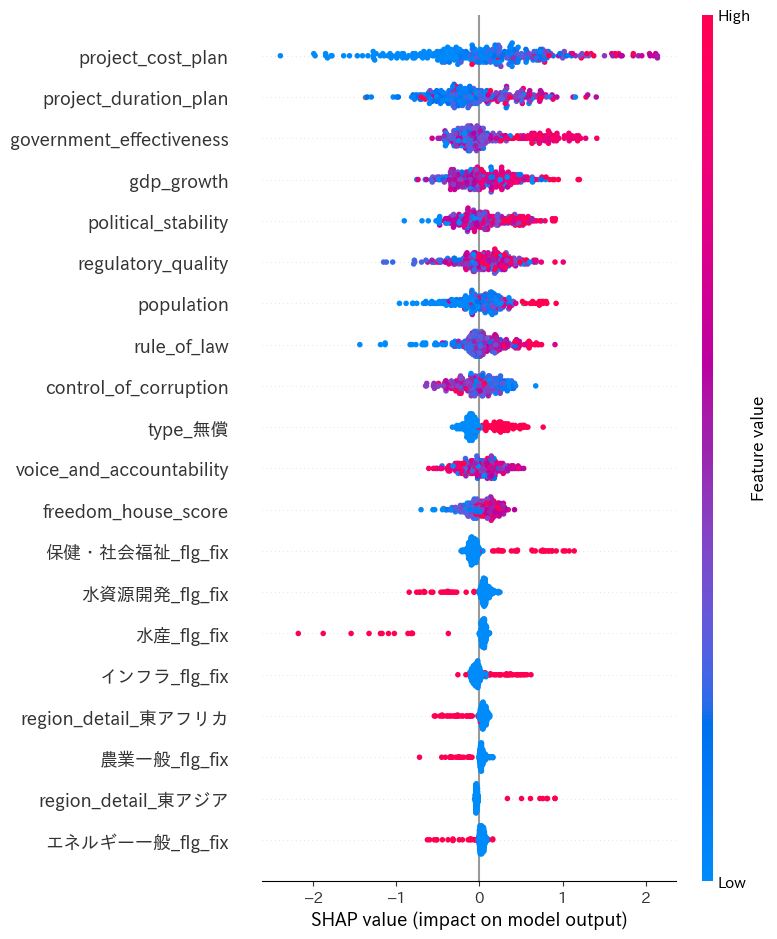

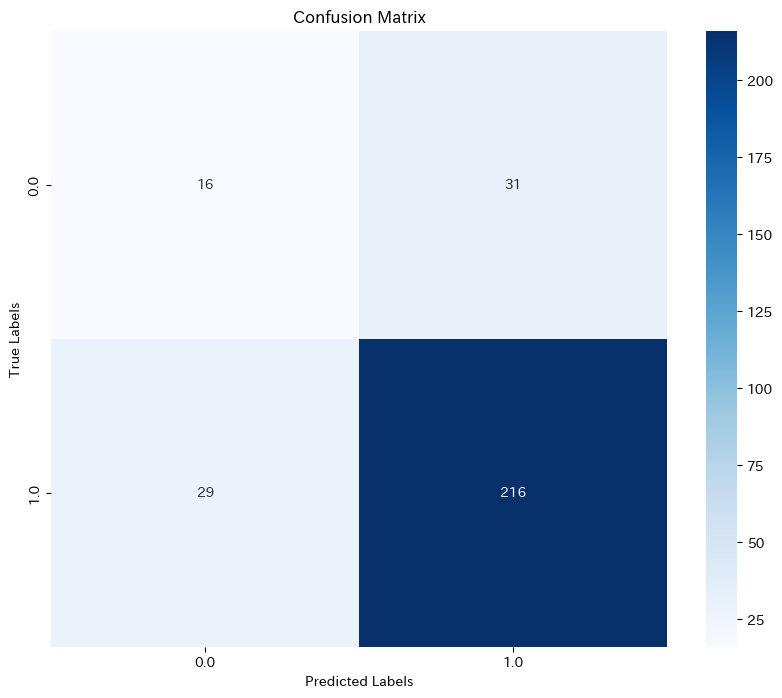

method, class, accuracy, precision, recall
proposed, all, 0.7945205479452054, 0.6150247413405309, 0.611029092488059
proposed, 0.0, non, 0.35555555555555557, 0.3404255319148936
proposed, 1.0, non, 0.8744939271255061, 0.8816326530612245
baseline, all, 0.7298977294051416, 0.5, 0.5
baseline, 0.0, non, 0.16095890410958905, 0.16095890410958905
baseline, 1.0, non, 0.839041095890411, 0.839041095890411


In [182]:
reload(ml_numerical_classification_xgb)
ml_numerical_classification_xgb.train_and_evaluate_model(train_df=train_df, valid_df=valid_df)

cm.vis('results/classification/confusion_matrix_num_xgb.csv','results/classification/result_num_xgb.csv')


## lgbm
- 数値系特徴量の追加

[LightGBM] [Info] Number of positive: 1119, number of negative: 382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2513
[LightGBM] [Info] Number of data points in the train set: 1501, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.745503 -> initscore=1.074770
[LightGBM] [Info] Start training from score 1.074770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


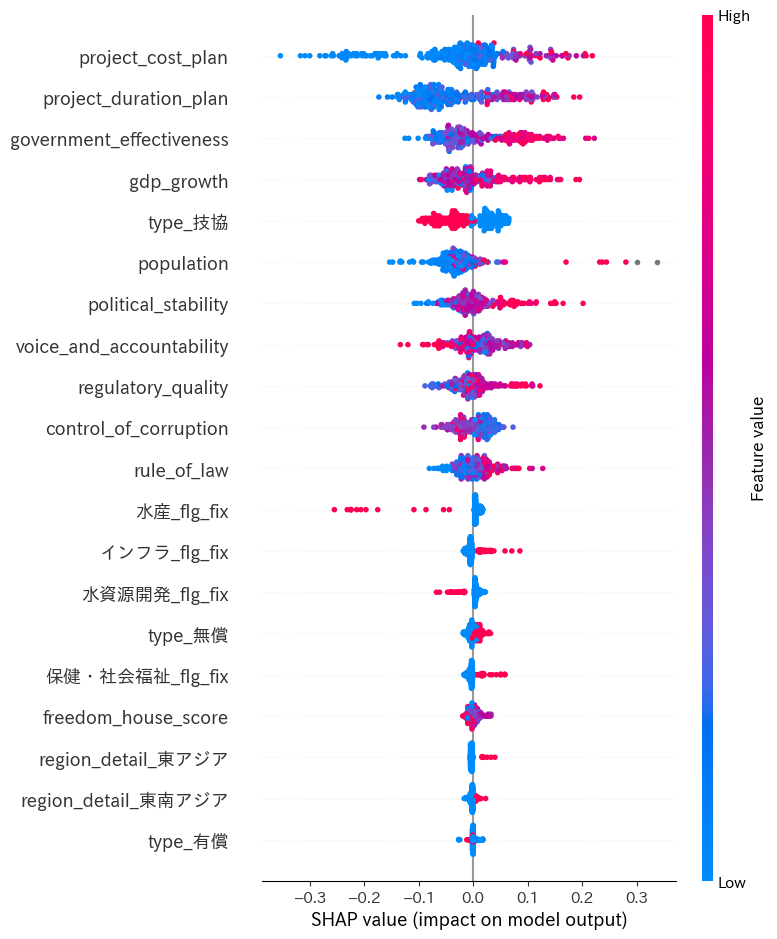

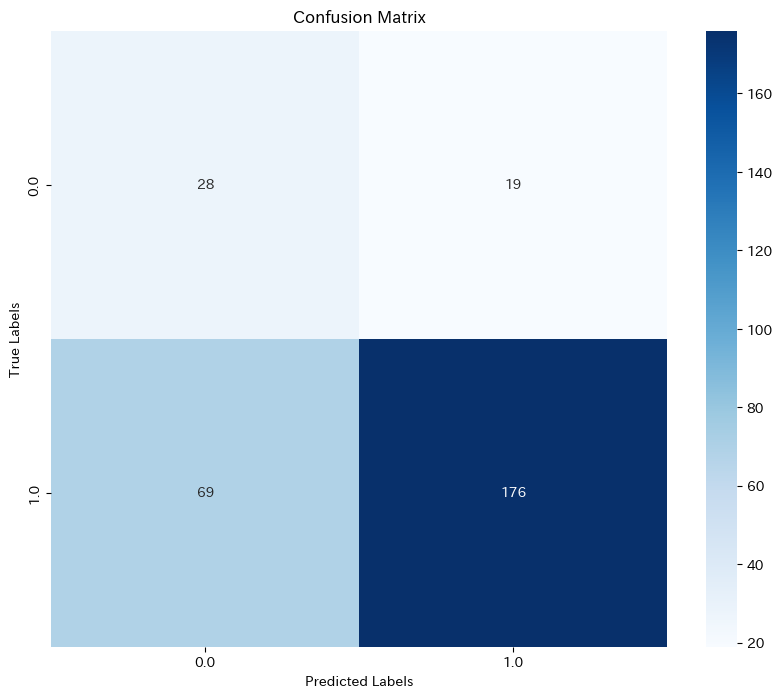

method, class, accuracy, precision, recall
proposed, all, 0.6986301369863014, 0.5956119481892678, 0.6570560138949196
proposed, 0.0, non, 0.28865979381443296, 0.5957446808510638
proposed, 1.0, non, 0.9025641025641026, 0.7183673469387755
baseline, all, 0.7298977294051416, 0.5, 0.5
baseline, 0.0, non, 0.16095890410958905, 0.16095890410958905
baseline, 1.0, non, 0.839041095890411, 0.839041095890411


In [190]:
reload(ml_numerical_classification_lgb)
ml_numerical_classification_lgb.train_and_evaluate_model(train_df=train_df, valid_df=valid_df, n_splits=5, threshold_objective="macro_f1")

cm.vis('results/classification/confusion_matrix_num_lgb.csv','results/classification/result_num_lgb.csv')
